# Detecting Sound Interference with Tensorflow/SKLearn for Hangout Sessions
By: Andor Kesselman

In this analysis, I inspect audio interference from multiple video streams. I employee three classification models, nearest neighbor, svm, and neural network to result in a binary predictor (Interference or No interference). 

###  Objectives: 

#### Purpose 1: To learn, specifically Tensorflow, SKLearn, Jupyter, cross-validation, better Python, Audio Processing
This was my first attempt at using tensorflow, sklearn, jupyter. Additionally, I rarely use python. I decided to treat this as a fun learning experience to get better at implementing classificaiton architecture. Additionally, I learned a lot about Audio/Signal Processing throughout this analysis. So overall, I am very happy with this. 

#### Purpose 2: Demonstrate an effective and practical soluation to a real world problem
A secondary goal of this was to demonstrate a practical solution to a real world problem. Frequently, when my colleagues and myself use hangouts, we log in at the same time with our computer. The problem is that multiple microphones on at the same time create an issue with loud feedback loops that greatly disrupt a meeting. Furthermore, often it is difficult to determine which of the incoming channels is responsible for disturbing the audio system. The goal of this network is to give Google the functionality to enable a "mute" action is multiple audio streams occur on the hangouts at the same time. 

#### Purpose 3: Get resourceful and employ cool techniques for bootstrapping data and working with limited resources. 
I am not an audio processing expert, nor do I have a large training set, but hopefully with enough creativity we can hack this problem away without requiring too much resources/data. I would be our hope that Google would action upon this analysis, and mute the interefering audio system followed by a prompt warning. 

Most of the audio processing in this is not novel. Much of these methods, use concepts that I am just brushing up upon, including a fourier transform, zero cross rates, and many more. I would consider this paper purely a demonstration application.

So we've plotted the values. Now we neeed to do some form of classification. 
To generate this, we create our own training and test set. 
First, we generate a single interference instance using google hangouts for ~5 mintues. 
We then then randomly sample 10 seconds from the 5 minutes.
Each sample then input a random noise variant using one of three different methods. 

# Import and Setup

In [316]:
# Helpers
import random
import os
from os import listdir
from os.path import isfile, join
import sys
import uuid

#Plotting and Math
from pylab import*
from scipy.io import wavfile
import matplotlib
import matplotlib.pyplot as plt
from numpy.lib import stride_tricks


# Classification and evaluation
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.cross_validation import StratifiedKFold, ShuffleSplit, cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier,KNeighborsRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Audio Libraries
#import audioFeatureExtraction
#import audioTrainTest as aT

#Debug
from pprint import pprint

sys.path.insert(0, './lib') #insert lib

In [317]:
#Define Paths
basedir = '/Users/andorkesselman/Documents/rnd/sound/src/'
dataset_dir = basedir + 'datasets/'
inter_dir_base = dataset_dir + 'base/interference_audio'
clean_dir_base = dataset_dir + 'base/clean_audio'
generated_dir = dataset_dir + 'generated/'
base_dataset = dataset_dir + 'base/'
inter_dir_gen = dataset_dir + 'generated/interference_audio/'
clean_dir_gen = dataset_dir + 'generated/clean_audio/'
PLOT_WIDTH  = 15
PLOT_HEIGHT = 3.5


# Dataset Generation And Reading

For Dataset generation, we will take existing audio files, induce some noise into the datastream, and then store them locally on the machine. This bootstrapping will allow us to generate lots of training data off of a relatively little sample set. If we were to expand the datasize, we could potentially do noise filtering while holding only one sound wav on file, finally storing only the meta data. This would probably be the best approach. The only problem with this is that we don't store the finalized sound files in the end, so this makes debugging more problematic. 

To test the veracity of the analysis, these files will be read and split into 5 fold cross validation set. 

There are a couple reservations that I have regarding dataset generation. Firstly, my top concern is variety of data. I can add noise, but I do not think there will be enough variety in the datasets to properly train the data. For example, I will not have different languages and there are a variety of settings at which this will not work. 

Where we improve the existing models I have seen is how we store the feature data. We will not store the actual waveform data, as that will be too instensive on memory/disk space. To reduce the amount of memory consumption, we will store the feature data (not the actual waveforms, on file to be read into memory). 

In [2]:
""" type: map
Sound File Storage: Useful for sound storage. Try to only store meta data if possible. All these are stores in a Features Objects. 
soundfiles[id] 
      -> label
      -> sampleRate
      -> fileLocation
      -> zcr
      -> waveFormData // This has to be stored in memory. Need to adjust moving forward. 
      -> rms
      -> spectralcentroid
      -> spectralrolloff
      -> spetral flux
"""

soundfiles = {}

class Features(object):   
    def __init__(self):
        pass 
"""
Label Storage: Useful for quick lookup. 
labelmap[label] -> list<id's with label>
"""
labelmap = {}

"""
Internal Mapping:
labelmap[id] -> soundfiles[id] 
"""

def generateSamples(base_dir, out_dir, suffix):
    
    print('Generating Training Data')
    audio_files = listFilesInDirectory(base_dir)
    count = 0
    iterations_per_file = 5 # the amount of sample files to be generate from each base file
    
    for file in audio_files:
        wav, sampleFreq = readWavFile(file)
        while (count < iterations_per_file):
            sample = sampleFile(wav)
            sample = randomNoiseGenerator(sample, sampleFreq)
            writeSample(sample, join(out_dir + str(count) + "_" + suffix + ".wav")) #write the sample and after adding noise. Naming convention malleable. 
            count+=1
            
            
""" Toss in the generated datasets. These are the final datasets. """
def readSamples(dataset_dir):

    # Store classification in folders
    for subdir in listSubDirectories(dataset_dir):
        spldir = subdir.split("/")
        classifier = spldir[len(spldir) - 1]
        print("Working on " + classifier  + " classifier right now ... Please wait")
        for file in listFilesInDirectory(subdir):
           
            # Check for collisions and create UUID
            uuid = generateUUID() 
            if uuid in soundfiles: #upon collision create new UUID. Assumes no second collision. 
                uuid = generateUUID() 
          
            #Add Features
            features = Features()
            features.label = classifier 
            features.fileLocation = file
            features.uuid = uuid
            fe = FeatureExtractor(features) 
            features = fe.extractFeatures()
            
            # Add Mapping for Easy LookUP of Classification to ID
            if features.label not in labelmap:
                idlist = []
                idlist.append(uuid)
                labelmap[str(features.label)] = idlist
            else:
                idlist = labelmap[str(features.label)]
                idlist.append(uuid) #add uuid
                labelmap[str(features.label)] = idlist
                
            soundfiles[uuid] = features  
            

## Noise Generators

In [265]:
""" 
The point of this is to introduce random noise variables to bootstrap the dataset. 
"""
def randomNoiseGenerator(sample, sampleFreq):
    r = random.randint(0, 3)

    if r == 0:
        return whiteNoise(sample)
    if r == 1:
        x = band_limited_noise(200, 2000, 44100, 44100)
        x = np.int16(x * (2**15 - 1))
        return x
    else:
        return sample

#Generate White Noise. 
def whiteNoise(array): 
    mean = 0
    std = 1 
    num_samples = 1000
    samples = np.random.normal(mean, std, size=num_samples)
    return array

#Generate Band Limited Noise
def fftnoise(f):
    f = np.array(f, dtype='complex')
    Np = (len(f) - 1) // 2
    phases = np.random.rand(Np) * 2 * np.pi
    phases = np.cos(phases) + 1j * np.sin(phases)
    f[1:Np+1] *= phases
    f[-1:-1-Np:-1] = np.conj(f[1:Np+1])
    return np.fft.ifft(f).real

def band_limited_noise(min_freq, max_freq, samples, samplerate=1):
    freqs = np.abs(np.fft.fftfreq(samples, 1/samplerate))
    f = np.zeros(samples)
    idx = np.where(np.logical_and(freqs>=min_freq, freqs<=max_freq))[0]
    f[idx] = 1
    return fftnoise(f)

## .Wav Support

In [266]:
def testNoiseGeneration():
    fileloc = '/Users/andorkesselman/Documents/rnd/sound/src/datasets/base/clean_audio/1_clean.wav'
    wav, sampleRate = readWavFile(fileloc)
    randomNoiseGenerator(wav, sampleRate)
    
testNoiseGeneration()


AttributeError: 'builtin_function_or_method' object has no attribute 'randInt'

In [256]:
# Read Wav File from Location Specified in Method Call
def readWavFile(wavfile_location):
    sampleFreq, sample = wavfile.read(wavfile_location)
    sample = sample / (2.**15) #normalize and center
    ch1 = sample[:,0] #take one channel. There are two channels in this scenario
    return ch1, sampleFreq

# Read Wav File from Location Specified in Method Call
def readWavFileAllChannels(wavfile_location):
    sampleFreq, sample = wavfile.read(wavfile_location)
    sample = sample / (2.**15) #normalize and center
    ch1 = sample[:,0] #take one channel. There are two channels in this scenario
    return sample, sampleFreq
 
# Write Audio Sample To File
def writeSample(sample, outdir):
    wavfile.write(outdir, 44100, sample)

""" Randomly Returns a Sample of a File. TODO: Improve Sampling Method.  
Must Remain a Sequence in this Case because Audio is time dependent. Randomly Sampling would be BAD. """
def sampleFile(wav):
    #take random 
    size = int(len(wav) / 5) # take 1/5 of the full file size. TODO: What's the best implemenation?
    i = int(len(wav) - size - 1)
    r = random.randint(0, i) # make sure that we get a full set. Hence the - size
    return wav[r:(r+size), ]


# Feature Extraction

OK, going into the project, I thought feature extraction would be relatively simple. I was thinking of just doing something like a nearest neighbor approach using the amplitude and frequencies of the wave as the feature. I quickly found out that to not be the case. This is complicated, and I relied heavily on prior work: http://www.ifs.tuwien.ac.at/~schindler/lectures/MIR_Feature_Extraction.html for guidance. 

In [319]:
""" 
Features Extraction, gives us the data to store things like the zcr, waveformdata, rms, etc into a feature object. 
type: map
Sound File Storage: Useful for sound storage. Try to only store meta data if possible. All these are stores in a Features Objects. 
soundfiles[id] 
      -> label
      -> sampleRate
      -> fileLocation
      -> zcr
      -> waveFormData // This has to be stored in memory. Need to adjust moving forward. 
      -> rms
      -> spectralcentroid
      -> spectralrolloff
      -> spetral flux
"""
class FeatureExtractor(object):

    def __init__(self, features):
        self.features = features
        
    def extractFeatures(self):
        waveform, sampleRate = readWavFileAllChannels(self.features.fileLocation)
        self.features.waveform = waveform
        self.features.sampleRate = sampleRate
        
        blocklength = 2048
       # self.features.zcr = zero_crossing_rate(waveform, blocklength, sampleRate)
       # self.features.rms = root_mean_square(waveform, blocklength, sampleRate)
       # self.features.spectral_centroid = spectral_centroid(waveform, blocklength, sampleRate)
       # self.features.spectral_rolloff = spectral_rolloff(waveform, blocklength, sampleRate)
      #  self.features.spectral_flux = spectral_flux(waveform, blocklength, sampleRate)

        return self.features


In [48]:
"""Simple check to make sure the feature extrator is working. Should be run only once."""
def testFeatureExtraction():
    print("Testing Feature Extractor")
    fileloc = '/Users/andorkesselman/Documents/rnd/sound/src/datasets/base/clean_audio/1_clean.wav'
    wav = readWavFile(fileloc)
    features = Features()
    features.fileLocation = fileloc
    features = FeatureExtractor(features).extractFeatures()
    pprint(vars(features))
    print("---------FEATURE EXTRATOR PASSED----------")

testFeatureExtraction()

Testing Feature Extractor
{'fileLocation': '/Users/andorkesselman/Documents/rnd/sound/src/datasets/base/clean_audio/1_clean.wav',
 'sampleRate': 44100,
 'waveform': array([[ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       ..., 
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.]])}
---------FEATURE EXTRATOR PASSED----------


### Transform Functions

Note: Most of these functions were taken from:

http://www.ifs.tuwien.ac.at/~schindler/lectures/MIR_Feature_Extraction.html. 

One could argue that we actually don't need this to accomplish our tasks. After all, we could probably take a nearest neighbor on a block by block basis to classify. This could be considered excessive. 

In [320]:
""" Short time forier transform """
def stft(sig, frameSize, overlapFac=0.5, window=np.hanning):
    
    # get the frame size and the hopsize
    win = window(frameSize)
    hopSize = int(frameSize - np.floor(overlapFac * frameSize))
    
    # zeros at beginning (thus center of 1st window should be for sample nr. 0)
    samples = np.append(np.zeros(np.floor(frameSize/2.0)), sig)    
    # cols for windowing
    cols = np.ceil( (len(samples) - frameSize) / float(hopSize)) + 1
    # zeros at end (thus samples can be fully covered by frames)
    samples = np.append(samples, np.zeros(frameSize))
    
    frames = np.lib.stride_tricks.as_strided(samples, shape=(cols, frameSize), strides=(samples.strides[0]*hopSize, samples.strides[0])).copy()
    frames *= win
    
    #use numpys computes the one-dimensional discrete Fourier Transform for real input.
    return np.fft.rfft(frames)    


""" scale frequency axis logarithmically. Not sure exactly how this function works. Need to revisit in due time. """    
def logscale_spec(spec, sr=44100, factor=20.): # TODO: The sample rate needs to be adjusted to the sample rate of the music
    timebins, freqbins = np.shape(spec) #Get the shape of the spec
    print("TimeBins are " , timebins , " Frequency Bins are " , freqbins)
    scale = np.linspace(0, 1, freqbins) ** factor  # what is the factor?
    scale *= (freqbins-1)/max(scale) #Scale values for bins. 
    scale = np.unique(np.round(scale)) #Round the interger values
    
    # create spectrogram with new freq bins
    newspec = np.complex128(np.zeros([timebins, len(scale)])) #real and complex number
    for i in range(0, len(scale)):
        if i == len(scale)-1:
            newspec[:,i] = np.sum(spec[:,scale[i]:], axis=1) 
        else:        
            newspec[:,i] = np.sum(spec[:,scale[i]:scale[i+1]], axis=1)
    
    # list center freq of bins
    allfreqs = np.abs(np.fft.fftfreq(freqbins*2, 1./sr)[:freqbins+1])
    freqs = []
    for i in range(0, len(scale)):
        if i == len(scale)-1:
            freqs += [np.mean(allfreqs[scale[i]:])]
        else:
            freqs += [np.mean(allfreqs[scale[i]:scale[i+1]])]
            
    
    return newspec, freqs


"""The following method is numerical more elegant and computationally efficient. It uses the optimized linear algebraic functions of the Numerical Python (numpy) package.
The method further computes the Zero Crossing Rate for a sequence of blocks (also called frames or windows)."""
def zero_crossing_rate(wavedata, block_length, sample_rate):
    
    # how many blocks have to be processed?
    num_blocks = int(np.ceil(len(wavedata)/block_length))
    
    # when do these blocks begin (time in seconds)?
    timestamps = (np.arange(0,num_blocks - 1) * (block_length / float(sample_rate)))
    
    zcr = []
    
    for i in range(0,num_blocks-1):
        
        start = i * block_length
        stop  = np.min([(start + block_length - 1), len(wavedata)])
        zc = 0.5 * np.mean(np.abs(np.diff(np.sign(wavedata[start:stop]))))
        zcr.append(zc)
    
    return np.asarray(zcr), np.asarray(timestamps)

""" Root mean squared calculates the relative energy. It uses the amplitude, but calculates the instantaneous energy. """
def root_mean_square(wavedata, block_length, sample_rate):
    
    # how many blocks have to be processed?
    num_blocks = int(np.ceil(len(wavedata)/block_length))
    
    # when do these blocks begin (time in seconds)?
    timestamps = (np.arange(0,num_blocks - 1) * (block_length / float(sample_rate)))
    
    rms = []
    
    for i in range(0,num_blocks-1):
        
        start = i * block_length
        stop  = np.min([(start + block_length - 1), len(wavedata)])
        
        rms_seg = np.sqrt(np.mean(wavedata[start:stop]**2))
        rms.append(rms_seg)
    
    return np.asarray(rms), np.asarray(timestamps)

""" Determines where the concentration of energy occurs. """
def spectral_centroid(wavedata, window_size, sample_rate):
    
    magnitude_spectrum = stft(wavedata, window_size)
    timebins, freqbins = np.shape(magnitude_spectrum)
    
    # when do these blocks begin (time in seconds)?
    timestamps = (np.arange(0,timebins - 1) * (timebins / float(sample_rate)))
    
    sc = []

    for t in range(timebins-1):
        power_spectrum = np.abs(magnitude_spectrum[t])**2      
        sc_t = np.sum(power_spectrum * np.arange(1,freqbins+1)) / np.sum(power_spectrum)
        sc.append(sc_t)
    
    sc = np.asarray(sc)
    sc = np.nan_to_num(sc)
    
    return sc, np.asarray(timestamps)


""" Computes the spectral rolloff which measures the skewness of the spectral shape. """
def spectral_rolloff(wavedata, window_size, sample_rate, k=0.85):
    
    # convert to frequency domain
    magnitude_spectrum = stft(wavedata, window_size)
    power_spectrum     = np.abs(magnitude_spectrum)**2
    timebins, freqbins = np.shape(magnitude_spectrum)
    
    # when do these blocks begin (time in seconds)?
    timestamps = (np.arange(0,timebins - 1) * (timebins / float(sample_rate)))
    
    sr = []
    spectralSum    = np.sum(power_spectrum, axis=1)
    
    for t in range(timebins-1):
        
        # find frequency-bin indeces where the cummulative sum of all bins is higher
        # than k-percent of the sum of all bins. Lowest index = Rolloff
        sr_t = np.where(np.cumsum(power_spectrum[t,:]) >= k * spectralSum[t])[0][0]
        
        sr.append(sr_t)
        
    sr = np.asarray(sr).astype(float)
    
    # convert frequency-bin index to frequency in Hz
    sr = (sr / freqbins) * (sample_rate / 2.0)
    
    return sr, np.asarray(timestamps)

""" Measures the rate of local change"""
def spectral_flux(wavedata, window_size, sample_rate):
    
    # convert to frequency domain
    magnitude_spectrum = stft(wavedata, window_size)
    timebins, freqbins = np.shape(magnitude_spectrum)
    
    # when do these blocks begin (time in seconds)?
    timestamps = (np.arange(0,timebins - 1) * (timebins / float(sample_rate)))
    
    sf = np.sqrt(np.sum(np.diff(np.abs(magnitude_spectrum))**2, axis=1)) / freqbins
    
    return sf[1:], np.asarray(timestamps)

# Utility

### Graphical Helpers

In [321]:
""" Shows the stereo waveform of both channels. """

def show_stereo_waveform(samples):

	fig = plt.figure(num=None, figsize=(PLOT_WIDTH, 5), dpi=72, facecolor='w', edgecolor='k')

	channel_1 = fig.add_subplot(211)
	channel_1.set_ylabel('Channel 1')
	channel_1.set_xlim(0,len(samples)) 
	channel_1.set_ylim(-1,1)
	channel_1.plot(samples[:,0])

	channel_2 = fig.add_subplot(212)
	channel_2.set_ylabel('Channel 2')
	channel_2.set_xlabel('Time (s)')
	channel_2.set_ylim(-1, 1)
	channel_2.set_xlim(0,len(samples)) 
	channel_2.plot(samples[:,1])

	plt.show();
	plt.clf();
    

"""  Takes the mean of both channels and outputs it as the mono wave form. """
def show_mono_waveform(samples):

	fig = plt.figure(num=None, figsize=(PLOT_WIDTH, PLOT_HEIGHT), dpi=72, facecolor='w', edgecolor='k')

	channel_1 = fig.add_subplot(111)
	channel_1.set_ylabel('Channel 1')
	channel_1.set_xlim(0,len(samples)) 
	channel_1.set_ylim(-1,1)

	channel_1.plot(samples)

	plt.show();
	plt.clf();
    

""" This is a spectogram plot. Please see: https://en.wikipedia.org/wiki/Spectrogram for more information. """
def plotstft(samples, samplerate, binsize=2**10, plotpath=None, colormap="jet", ax=None, fig=None):
    
    # Get the 1 dimensional Short Fourier Transform using the numpy's ftf function 
    s = stft(samples, binsize)
    
    #move the ferequence to log scale. 
    sshow, freq = logscale_spec(s, factor=1.0, sr=samplerate)
    ims = 20.*np.log10(np.abs(sshow)/10e-6) # amplitude to decibel
    
    timebins, freqbins = np.shape(ims)
    
    if ax is None:
        fig, ax = plt.subplots(1, 1, sharey=True, figsize=(PLOT_WIDTH, 3.5))
    
    #ax.figure(figsize=(15, 7.5))
    cax = ax.imshow(np.transpose(ims), origin="lower", aspect="auto", cmap=colormap, interpolation="none")
    #cbar = fig.colorbar(cax, ticks=[-1, 0, 1], cax=ax)
    #ax.set_colorbar()

    #label
    ax.set_xlabel("time (s)")
    ax.set_ylabel("frequency (hz)")
    ax.set_xlim([0, timebins-1])
    ax.set_ylim([0, freqbins])

    xlocs = np.float32(np.linspace(0, timebins-1, 5))
    ax.set_xticks(xlocs, ["%.02f" % l for l in ((xlocs*len(samples)/timebins)+(0.5*binsize))/samplerate])
    ylocs = np.int16(np.round(np.linspace(0, freqbins-1, 10)))
    ax.set_yticks(ylocs, ["%.02f" % freq[i] for i in ylocs])
    
    if plotpath:
        plt.savefig(plotpath, bbox_inches="tight")
    else:
        plt.show()
        
    #plt.clf();
    b = ["%.02f" % l for l in ((xlocs*len(samples)/timebins)+(0.5*binsize))/samplerate]
    return xlocs, b, timebins

""" Show super imposed feature set
TODO: This feature will not work yet because lookup is not working. """
def show_feature_superimposed(genre, feature_data, timestamps, squared_wf=False):
    
    # plot spectrogram. Get all the sounds files and sample rate for each of the files. Returns the xlocs, b, and timebins. 
    a,b,c = plotstft(sound_files[genre]["wavedata"], sound_files[genre]["samplerate"]);

    fig = plt.figure(num=None, figsize=(PLOT_WIDTH, PLOT_HEIGHT), dpi=72, facecolor='w', edgecolor='k');
    channel_1 = fig.add_subplot(111);
    channel_1.set_ylabel('Channel 1');
    channel_1.set_xlabel('time');

    # plot waveform
    scaled_wf_y = ((np.arange(0,sound_files[genre]["wavedata"].shape[0]).astype(np.float)) / sound_files[genre]["samplerate"]) * 1000.0
    
    if squared_wf:
        scaled_wf_x = (sound_files[genre]["wavedata"]**2 / np.max(sound_files[genre]["wavedata"]**2))
    else:
        scaled_wf_x = (sound_files[genre]["wavedata"] / np.max(sound_files[genre]["wavedata"]) / 2.0 ) + 0.5
    
    #scaled_wf_x = scaled_wf_x**2
    
    plt.plot(scaled_wf_y, scaled_wf_x, color='lightgrey');

    # plot feature-data
    scaled_fd_y = timestamps * 1000.0
    scaled_fd_x = (feature_data / np.max(feature_data))
    
    plt.plot(scaled_fd_y, scaled_fd_x, color='r');

    plt.show();
    plt.clf();

### File Helpers

In [322]:
""" List the files in the directory """
def listFilesInDirectory(directory):
    ret = []
    for file in listdir(directory):
            ret.append(join(directory, file))
    return ret

""" List the directories in a parent directory. Returns a list of directories. """
def listSubDirectories(directory):
    ret = []
    for subdirectory in listdir(directory):
            path = join(directory, subdirectory)
            if(os.path.isdir(path)):
                ret.append(path)
    return ret

""" Generate Random UUID """
def generateUUID():
    return uuid.uuid4() 

def testFileHelpers():
    print("Listing Files in Directory")
    print(listFilesInDirectory(inter_dir_gen))
    print("Listing SubDirectories")
    print(listSubDirectories(dataset_dir))

# Classification

In the training data, we will split up all the files in the training set into 5 k-folds, with 3 kfolds for the original training data, 1 k fold for parameter turning, and then the final validation set.

In [239]:

""" SVM Approach has a couple of weaknesses. 

Advantages:
  1) Regularlization
  2) No local minima
  
Disadvantages:
  1) Kernel choice 
  2) Speed 

"""

class SVM():

    def __init__(self, X, labels):
        print("Selected SVM approach. ")
        if(len(X) != len(labels)):
            print("X must be the same size of the labels. Not matching.")
            print("Please input fields such as X = [[0, 0], [1, 1]], labels = [0, 1]")
            print("Note that both of these are length two")
        
        self.X = X
        self.labels = labels
    
    def Train(self):
        svm_classifier = svm.SVC(C=1)
        self.svm = svm_classifier
        svm_classifier.fit(self.X, self.labels) 
        print("Finished Training SVM Classifier")
    
    def Predict(self, X):
        prediction = self.svm.predict(X)
        return prediction
    

In [190]:
""" For the Nearest Neighbor Calculation. 
    We are going to use the Eucliedean L2 Distance Calclation as it is less biased to outliers. """
class KNearestNeighbor():
    
    def __init__(self, X, labels, n_neighbors):
        self.neighbors = n_neighbors
        print("Initiated K Nearest Neighbor with", n_neighbors, "neighbors.")
        self.X = X
        self.labels = labels
    
    def SKLearnFit(self):
        knn = KNeighborsClassifier(n_neighbors= self.neighbors)
        knn.fit(self.X, self.labels)
        self.knn = knn

    def SKLearnPredict(self, X):
        predictions = self.knn.predict(X)
        return predictions
    
    # calculate Euclidean Distance L2 distance
    def EuclideanDistanceCalculation():
        distances_l2 = np.sqrt((( self.X - self.Y))**2).sum(axis=1)
        sorted_dist_idx = np.argsort(distances_l2)
   

In [77]:
""" Neural Newtork Appraoch. Basically, this will be similar to a convolution image approach. 
Basically, I expect to take mini samples of the data, and then use those mini samples to characterize "features".
These features will be used to determine whether the sound is a interference sounds. 
"""
class NeuralNetwork(object):
    
    def __init__(self):
        print('Creating a Neural Network Using Tensorflow')
        pass
    


In [327]:
"""Simple method to test each classifier and make sure they are working. A more robhust classification methodology would be perferable"""
def testClassifiers():
    #testKNN()
    testSVM()
    
def testKNN():
    X = [[0, 0], [1, 1], [0, 10], [1, 100]]
    y = ["apple", "pear", "banana", "pear"]
    
    knn = KNearestNeighbor(X,y,2)
    knn.SKLearnFit()
    pred_input = [0,2]
    prediction = knn.SKLearnPredict(X)
    print("KNN Prediction is ", prediction)
    
def testSVM():
    # 2 column.
    # X, Y
    # 0  0 
    # 1  1
    #TODO: Fix
    X = [[0, 0], [1, 1]]
    y = ["apple", "pear"]
    svm = SVM(X, y)
    svm.Train()
    pred_input = [0,2]
    prediction = svm.Predict(pred_input)
    print("SVM Prediction is ", prediction)
    
testClassifiers()

Selected SVM approach. 
Finished Training SVM Classifier
SVM Prediction is  ['pear']


/Users/andorkesselman/anaconda3/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


# Cross Validation

In [314]:
"""
Data is assuming a mapping between X and y. It is not assuming the data is in feature space. This will be done later. 
"""

"""
Input -> labelmap
"""
class CrossValidation(object):
   
    def __init__(self,data, folds):
        self.data = data       
        self.X = []
        self.label = []
        self.KFolds(folds)
        print("--------", type(self.X))

    
    def KFolds(self, size):
        
        self.size = size
        self.count = 0
        if self.size <= 3:
            print("Size must be greater than 3. You need at least 2 free folds for test and validation")
            return
   
        
        # We have a 1 to many mapping. Need to make it a 1 to 1 mapping. 
        for label, values in self.data.items():
            print("Going through ", label, " Self x is ", type(self.X))

            for fileid in values:
                self.count += 1
                if(label == "" or fileid == ""):
                    print("Empty Mapping Value. Please check why.")
                    continue
                self.X = self.X  + [[soundfiles[fileid].sampleRate, self.count]] #note: Append was acting weird in this case. Not sure why. 
                self.label = self.label + [label]

        
        # For more information on Cross Validaition using SKLearn: Please check out the documentation at http://scikit-learn.org/stable/modules/cross_validation.html
        skf = StratifiedKFold(self.label, self.size)
        self.skf = skf
        return skf
      
    def Accuracy(self):
        #build classifier
        classifier = SVM(self.X, self.label)
        classifier.Train()
        scores = cross_val_score(classifier.svm, self.X, self.label, cv=self.size)
        print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))



In [315]:
def testCrossValidation():
    readSamples(base_dataset)
    cv = CrossValidation(labelmap,4)
    cv.Accuracy()
    
testCrossValidation()

Working on clean_audio classifier right now ... Please wait
Working on interference_audio classifier right now ... Please wait
Going through  interference_audio  Self x is  <class 'list'>
Going through  clean_audio  Self x is  <class 'list'>
-------- <class 'list'>
Selected SVM approach. 
Finished Training SVM Classifier
Accuracy: 0.54 (+/- 0.01)


# Validation

# Main

In [98]:
def testFileViewer():
    samples, freq = readWavFileAllChannels(clean_dir_base + "/1_clean.wav")
    show_stereo_waveform(samples)
    
#Run 
def testFouriuerViewer():
    samples, freq = readWavFileAllChannels(clean_dir_base + "/1_clean.wav")
    plotstft(samples, freq)

def test():
    testFileViewer()
    testFouriuerViewer()
    
def run():
    test()
    

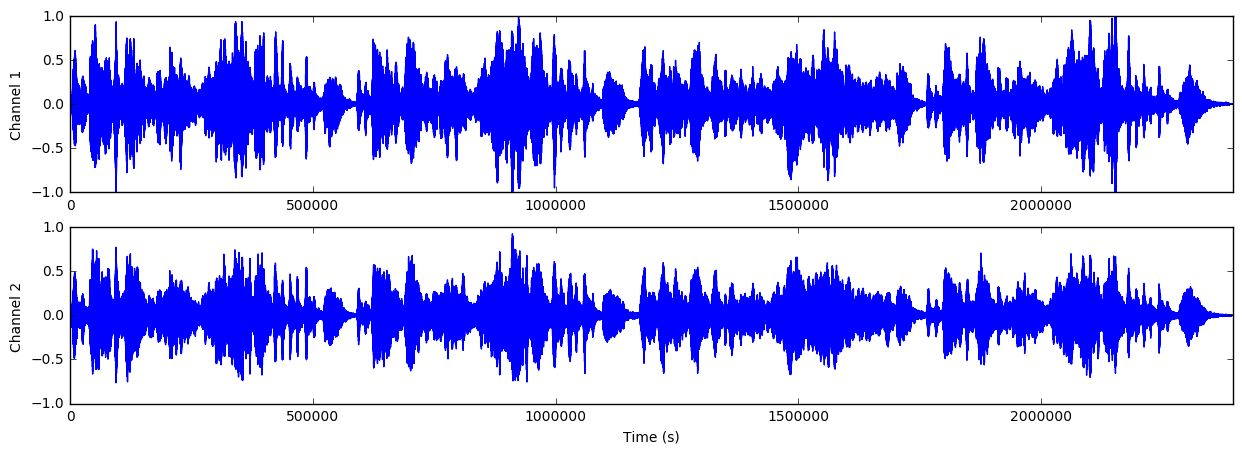

/Users/andorkesselman/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/andorkesselman/anaconda3/lib/python3.5/site-packages/numpy/core/numeric.py:482: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return array(a, dtype, copy=False, order=order)


TimeBins are  9357  Frequency Bins are  513


/Users/andorkesselman/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:36: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/andorkesselman/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:34: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/andorkesselman/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:45: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/andorkesselman/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:43: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


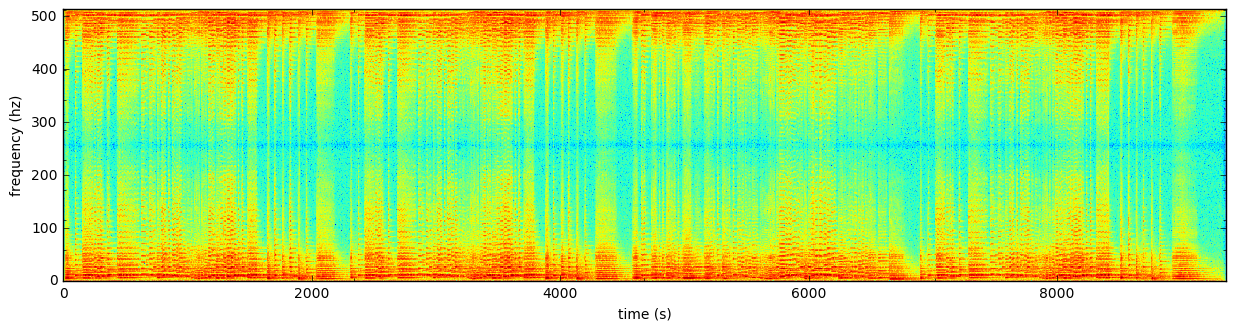

Running


In [102]:
run()

# Resources

### Note: For Prototyping purposes, I'm going to be using PyAudio from
https://github.com/tyiannak/pyAudioAnalysis

https://github.com/tracek/Ornithokrites


CNN
http://yerevann.github.io/2015/10/11/spoken-language-identification-with-deep-convolutional-networks/
http://research.microsoft.com/en-us/um/people/dongyu/nips2009/papers/montavon-paper.pdf

SVM
http://www.ee.columbia.edu/~sfchang/course/spr-F05/papers/guo-li-svm-audio00.pdf